# High Throughput Growth Experiment Analysis in Biotechnology
***

## Background
Biotechnology requires knowledge of microbial physiology and metabolism. Among the most important information is the growth rate and the substrate uptake rate. Both can be used to calculate the effectiveness of biotechnological production strategies and biomass and product yields. To identify an organism with suitable growth parameters, multiple strains, mutants or environmental conditions are tested which results in high throughput data. To analyse high throughput data computational approaches can speed up the process.

There are different growth phenotypes: exponential, linear, saturated, diauxie. The typical microbial saturated growth is divided in different growth phases, lag, log, stationary, and death phase.

Laws to describe a biomass $N$ include: 
- exponential law: 
  - $N(t) = N_0e^{\mu t}$
    - $N_0$: initial biomass, gDW/L
    - $\mu$: growth rate, /h
    - $t$: duration, h
- logistic growth law (Verhulst): 
  - $N(t) = \frac{K}{1+\left( \frac{K-N_0}{N_0}e^{-\mu t} \right)}$
    - $N_0$: initial biomass, gDW/L
    - $\mu$: growth rate, /h
    - $t$: duration, h
    - $K$: carrying capacity, max biomass, gDW/L
- Gompertz function: 
  - $N(t) = N_0e^{\left(\textrm{ln} \left(\frac{K}{N_0} \right)\left(1 - e^{-\mu t} \right) \right)}$
    - $N_0$: initial biomass, gDW/L
    - $\mu$: growth rate, /h
    - $t$: duration, h
    - $K$: carrying capacity, max biomass, gDW/L
- Baranyi model: complex model, see [literature](https://doi.org/10.1006/fmic.1999.0285)

The growth rate is a function of the substrate level and can be calculated via the Monod equation:
- $\mu = \frac{\mu_{max}S}{K_S + S}$
  - $\mu$: growth rate, /h
  - $\mu_{max}$: maximum growth rate, /h
  - $S$: Substrate concentration, mmol/L
  - $K_S$: half velocity constant, the value of S when $\frac{\mu}{\mu_{max}} = 0.5$, mmol/L

## Objective
1. Determine the optimal growth temperature
2. Calculate the growth rate and substrate uptake rate at different substrate concentrations
3. Evaluate the growth yields

### Additional information:
- Hagen, Exponential growth of bacteria: Constant multiplication through division, American Journal of Physics, 2010. doi [10.1119/1.3483278](https://doi.org/10.1119/1.3483278)
- Verduyn et al., A theoretical evaluation of growth yields of yeasts, Antoie van Leeuwenhoek, 1991. doi [10.1007/BF00582119](https://doi.org/10.1007/BF00582119)
- Pirt, The maintenance energy of bacteria in growing cultures, 1965. doi [10.1098/rspb.1965.0069](https://doi.org/10.1098/rspb.1965.0069)

## Workflow

**1 Set-up of simulation environment**
 * *1.1 Loading Python libraries and functions*
 * *1.2 Seeding your individual organism*

**2 High Throughput Temperature measurements**
 * *2.1 96-well plate experiment simulation* 
 * *2.2 Python based data analysis*
 * *2.3 Data export to Excel*
 
**3 Substrate uptake rates**
 * *3.1 Experiment setup (temperature, substrate concentrations, duration)*
 * *3.2 Data analysis*
 * *3.3 Data export to Excel* 

**4 Yield calculations**
 * *4.1 Yield formula*
 * *4.2 Assessment against published yields*

**5 Evaluation by peer review**
 * *5.1 Report of results*
 * *5.2 Peer review*

In [1]:
# Loading of important functionalities for the notebook:
# Loading numpy, a library fo manipulation of numbers:
import os
import numpy as np
# Loading matplotlib, a library for visualization:
import matplotlib.pyplot as plt
# Initialization, loading of all laboratory functionalities and stored models and information of the organisms:
# from FermProSimFun import MonodModel as Model

try:
    import silvio
except ImportError:
    print("silvio not found, installing...")
    %pip install silvio
    import silvio
from silvio.catalog.RecExpSim import RecExperiment, combine_data
from silvio.extensions.records.gene.crafted_gene import CraftedGene

from silvio.catalog.GroExpSim import *# GrowthExperiment
print('silvio version: ',silvio.__version__)
print('System ready')

silvio not found, installing...
Note: you may need to restart the kernel to use updated packages.
silvio version:  0.2.4
System ready


In [2]:
exp = GrowthExperiment(1617, 2000, 10000)

Organism = 'ecol'
host = exp.create_host(Organism)
exp.print_status()

Experiment:
  budget = 8000
  failure rate = 0.12
  hosts = [ ecol ]


In [19]:
vars(host.growth)

{'opt_growth_temp': 30,
 'max_biomass': 75,
 'Ks': 5.544,
 'Yxs': 0.34,
 'k1': 0.156,
 'umax': 0.314,
 'OD2X': 0.366,
 'make_generator': <bound method Host.make_generator of <silvio.catalog.GroExpSim.GroHost object at 0x7fd2285bad60>>}

In [3]:
Temperatures = np.arange(22,38,2)# [32, 30, 28, 26]
FileName = 'TempGrowthExperiment.csv'
exp.measure_TemperatureGrowth(Organism, Temperatures, FileName)
exp.print_status()

############################################# progress of exp.0 at 22 °C: 100 percent
############################################# progress of exp.1 at 24 °C: 100 percent
############################################# progress of exp.2 at 26 °C: 100 percent
############################################# progress of exp.3 at 28 °C: 100 percent
############################################# progress of exp.4 at 30 °C: 100 percent
############################################# progress of exp.5 at 32 °C: 100 percent
############################################# progress of exp.6 at 34 °C: 100 percent
############################################# progress of exp.7 at 36 °C: 100 percent
Data exported to: /home/ulf/Documents/2109_BLS+SILVIO/biolabsim_dev/Data/TempGrowthExperiment.csv
Experiment:
  budget = 7900
  failure rate = 0.12
  hosts = [ ecol ]


Text(0, 0.5, 'ln(Biomass)')

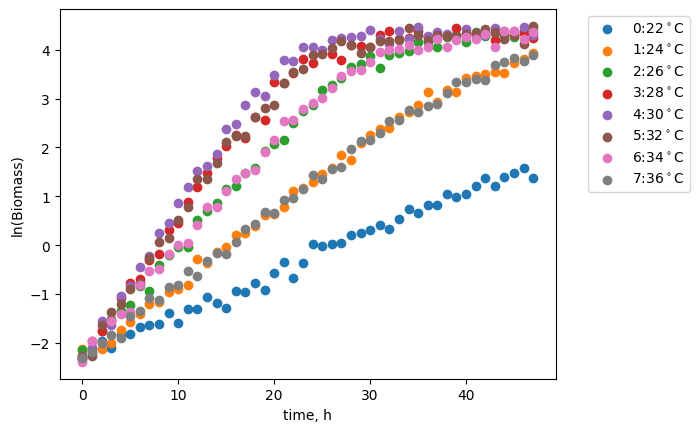

In [4]:
# Insert the correct code sequence for plotting in this cell.
# %load Snippets/rev_GrowthPlot.py 
DataFile = os.path.join('..', 'Data',FileName)
my_data = np.genfromtxt(DataFile, delimiter=',', skip_header=1)
Time, Biomass = my_data[:,0], my_data[:,1:]
LnBiomass = np.log(Biomass)
[plt.scatter(Time, X, label=Exp) for Exp,X in enumerate(LnBiomass.T)]
plt.legend([r'{}:{}$^\circ$C'.format(Idx, T) for Idx, T in enumerate(Temperatures)], bbox_to_anchor=(1.05, 1), loc='upper left'); plt.xlabel('time, h'); plt.ylabel('ln(Biomass)')


In [5]:
# Rearrange the correct code sequence for calculating the growth and biomass parameters here.
# For None enter the corresponding values of experiment index with fastest growth and latest time of linear growth (integer number).
# %load Snippets/snip_GrowthPars.py

Idx_optT, Linear_optT = 4, 6
MB_mean = np.mean(Biomass[Linear_optT:,Idx_optT])
MB_std = np.std(Biomass[Linear_optT:,Idx_optT])
print('Biomass: {:.2f}±{:.2f} g/L'.format(MB_mean, MB_std))
GR, cov = np.polyfit(Time[:Linear_optT],LnBiomass[:Linear_optT,Idx_optT],1, cov=True)
GR_mean, GR_std = GR[0], np.sqrt(np.diag(cov))[0]
print('Growth rate: {:.2f}±{:.2f} /h'.format(GR_mean, GR_std))


Biomass: 48.96±31.32 g/L
Growth rate: 0.29±0.04 /h


## Optical density to dry weight conversion
In literature the standard reporting for biomass is gramm dry weight (gDW). In the lab, the measurement by optical density is typical and thus, a conversion between these units need to be established. Typically, a culture is grown for a period of time and harvested during exponential growth. All liquid is removed by baking in the oven or microwave and the remaining biomass powder is weighted.

In the following, you conduct an experiment to determine the conversion factor. Choose the optimal temperature, and appropriate values for cultivation time and substrate concentration to end approximately in exponential phase. The result is stored in a csv-file in the Data folder.

In [7]:
Temperature = 30
FinalTime = 50
SubstrateConc = 10
Replicates = 3
FileName = f'OD-DryWeight_{Temperature}C_{FinalTime}h_{SubstrateConc}M.csv'
exp.measure_DryWeight(Organism, Temperature, FinalTime, SubstrateConc, Replicates, FileName)

Data exported to: /home/ulf/Documents/2109_BLS+SILVIO/biolabsim_dev/Data/OD-DryWeight_30C_50h_10M.csv


DataOutcome(value=      t      X      S     OD
0  50.0  3.492  0.325  9.541
1  50.0  3.224  0.481  8.809
2  50.0  3.309  1.223  9.041, error=None)

#### Calculation of the conversion factor
The conversion factor is simply calculated by dividing the biomass dry weight with the OD. The factor can be multiplied to the OD to get the corresponding dry weight.

In [8]:
DataFile = os.path.join('..', 'Data',FileName)
my_data = np.genfromtxt(DataFile, delimiter=',', skip_header=1)
DryWeight, OD = my_data[:,1], my_data[:,3]
OD2XAvg = round(np.average(DryWeight/OD),3)
OD2XStd = round(np.std(DryWeight/OD),3)
print(f'The OD to dry weight conversion factor: {OD2XAvg}±{OD2XStd} (gDW/L)/OD')

The OD to dry weight conversion factor: 0.366±0.0 (gDW/L)/OD


In [17]:
Temperature = 30
SubstrateConc = 1
TotalTime = 52
SamplingTime = 2
NightStart = 5
# The data is saved in the 'Data' subfolder. Choose the name of the file and add description of the experiment, like the substrate concentration, Temperature, etc.
FileName = f'SubstrateGrowthExp__{Temperature}C_{TotalTime}h_{SubstrateConc}gL-1.csv' # add file type .csv

myDat = exp.measure_BiomassSubstrateExp('ecol', Temperature, [TotalTime, SamplingTime], SubstrateConc, NightStart, FileName)
exp.print_status()

############################################# progress experiment: 100 percent
Data exported to: /home/ulf/Documents/2109_BLS+SILVIO/biolabsim_dev/Data/SubstrateGrowthExp__30C_52h_1gL-1.csv
Experiment:
  budget = 7232
  failure rate = 0.12
  hosts = [ ecol ]


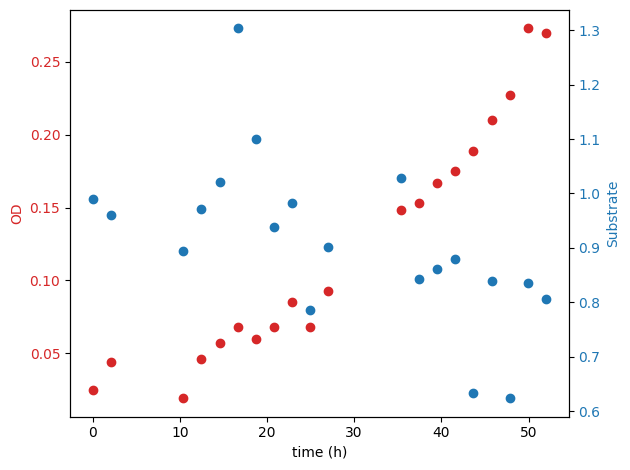

In [18]:
# loading of data csv file to dataframe
ExperimentFile = os.path.join('..', 'Data', FileName)
df = pd.read_csv(ExperimentFile, sep=',', header=0)
# Scatter plot of the data with two y axis for OD and substrate concentration
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (h)')
ax1.set_ylabel('OD', color=color)
ax1.scatter(df['t'], df['OD'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Substrate', color=color)  # we already handled the x-label with ax1
ax2.scatter(df['t'], df['S'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Do the data analysis

## Check your results
Testing values of:
- Optimal temperature
- OD to dry weight correlation
- Growth rate
- Maximum biomass
- Growth yield
- Glucose concentration with half maximum uptake rate
- Glucose maximum uptake rate

In [3]:
# Maximum growth rate
Temperature = 28
MaxBiomass = 30
OD2X = .46
GrowthYield_Avg = 0.29
GrowthYield_Std = 0.01
GrowthRate_Avg = .15
GrowthRate_Std = .05
GlcRateMax_Avg = 2.6
GlcRateMax_Std = .5
Ks_Avg = 1.4
Ks_Std = .03

Results = {'Temperature': Temperature,
           'MaxBiomass': MaxBiomass,
           'OD2X': OD2X,
           'GrowthYield_Avg': GrowthYield_Avg, 'GrowthYield_Std': GrowthYield_Std,
           'GrowthRate_Avg':GrowthRate_Avg, 'GrowthRate_Std':GrowthRate_Std, 
           'GlcRateMax_Avg': GlcRateMax_Avg, 'GlcRateMax_Std': GlcRateMax_Std,
           'Ks_Avg': Ks_Avg, 'Ks_Std': Ks_Std,
           } #

In [4]:
exp.check_Results(Organism, Results)

GlcRateMax: 2.6±0.5 mmol/gDW/h ❌ Value is 5.4x standard deviations from the reference value
GrowthRate: 0.15±0.05 /h ❌ Value is 2.3x standard deviations from the reference value
GrowthYield: 0.29±0.01 g/g ✅
Ks: 1.4±0.03 g/L ❌ Value is 38.7x standard deviations from the reference value
MaxBiomass: 30 gDW/L ✅
OD2X: 0.46 a.u. ✅
Temperature: 28 °C ✅


In [5]:
vars(host.growth)

{'opt_growth_temp': 28,
 'max_biomass': 31,
 'Ks': 2.562,
 'Yxs': 0.28,
 'k1': 0.156,
 'umax': 0.266,
 'OD2X': 0.459,
 'make_generator': <bound method Host.make_generator of <silvio.catalog.GroExpSim.GroHost object at 0x7f5f9055ce50>>}